# 16.7 - Feature Engineering 1: From Variables to Features

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
import warnings

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student = pd.read_sql_query('select * from studentsperformance',con=engine)

engine.dispose()

# Question 1

Are exam scores normally distributed?

In [4]:
student.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


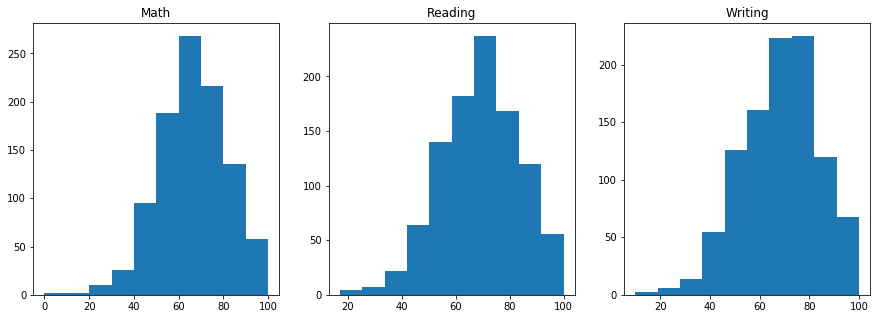

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(student['math score'])
plt.title('Math')

plt.subplot(1,3,2)
plt.hist(student['reading score'])
plt.title('Reading')

plt.subplot(1,3,3)
plt.hist(student['writing score'])
plt.title('Writing')

plt.show()

In [37]:
for var in ['math score', 'reading score', 'writing score']:
    #results = student[tests[i]]
    jbtest = jarque_bera(student[var])
    ntest = normaltest(student[var])
    print(var.title()+':')
    print('Jarque-Bera test statistic: {} \tJargue-Bera p-value: {}'.format(round(jbtest[0],2),round(jbtest[1],4)))
    print('Normatlity test statistic: {} \tNormality p-value: {}'.format(round(ntest[0],2),round(ntest[1],4)))
    print('')

Math Score:
Jarque-Bera test statistic: 15.91 	Jargue-Bera p-value: 0.0004
Normatlity test statistic: 15.41 	Normality p-value: 0.0005

Reading Score:
Jarque-Bera test statistic: 11.38 	Jargue-Bera p-value: 0.0034
Normatlity test statistic: 11.12 	Normality p-value: 0.0039

Writing Score:
Jarque-Bera test statistic: 13.99 	Jargue-Bera p-value: 0.0009
Normatlity test statistic: 13.61 	Normality p-value: 0.0011



While they look fairly similar to a normal distribution, all our tests reject normality for all 3 exam types.

In [62]:
math_bc,_ = boxcox(student[student['math score'] > 0]['math score'])
reading_bc,_ = boxcox(student['reading score'])
writing_bc,_ = boxcox(student['writing score'])

bc_vars = [math_bc, reading_bc, writing_bc]
var_names = ['math score', 'reading score', 'writing score']

for i in range(3):
    jbtest = jarque_bera(bc_vars[i])
    ntest = normaltest(bc_vars[i])
    print(var_names[i].title()+':')
    print('Jarque-Bera test statistic: {} \tJargue-Bera p-value: {}'.format(round(jbtest[0],2),round(jbtest[1],4)))
    print('Normatlity test statistic: {} \tNormality p-value: {}'.format(round(ntest[0],2),round(ntest[1],4)))

Math Score:
Jarque-Bera test statistic: 1.72 	Jargue-Bera p-value: 0.4231
Normatlity test statistic: 1.83 	Normality p-value: 0.4001
Reading Score:
Jarque-Bera test statistic: 4.12 	Jargue-Bera p-value: 0.1275
Normatlity test statistic: 5.28 	Normality p-value: 0.0713
Writing Score:
Jarque-Bera test statistic: 4.75 	Jargue-Bera p-value: 0.0932
Normatlity test statistic: 6.27 	Normality p-value: 0.0436


Our tests indicate the modified values are closer to normality.

# Question 2

See if the average of students' test scores is normally distributed:

In [82]:
for row in range(len(student)):
    student.loc[row,'avg score'] = np.mean(student.iloc[row,5:8])

jbtest = jarque_bera(student['avg score'])
ntest = normaltest(student['avg score'])

print('Jarque-Bera test statistic: {} \tJargue-Bera p-value: {}'.format(round(jbtest[0],2),round(jbtest[1],4)))
print('Normatlity test statistic: {} \tNormality p-value: {}'.format(round(ntest[0],2),round(ntest[1],4)))

Jarque-Bera test statistic: 15.45 	Jargue-Bera p-value: 0.0004
Normatlity test statistic: 15.19 	Normality p-value: 0.0005


The average of a students' 3 test scores is not normally distributed. Let's try after applying a Box-Cox transformation.

In [83]:
new_avg,_ = boxcox(student['avg score'])

jbtest = jarque_bera(new_avg)
ntest = normaltest(new_avg)

print('Jarque-Bera test statistic: {} \tJargue-Bera p-value: {}'.format(round(jbtest[0],2),round(jbtest[1],4)))
print('Normatlity test statistic: {} \tNormality p-value: {}'.format(round(ntest[0],2),round(ntest[1],4)))

Jarque-Bera test statistic: 2.44 	Jargue-Bera p-value: 0.2959
Normatlity test statistic: 2.78 	Normality p-value: 0.2491


Yes, after applying the Box-Cox transformation, we can no longer reject the assumption of normality.

# Question 3

Which variables are correlated with our target variable?

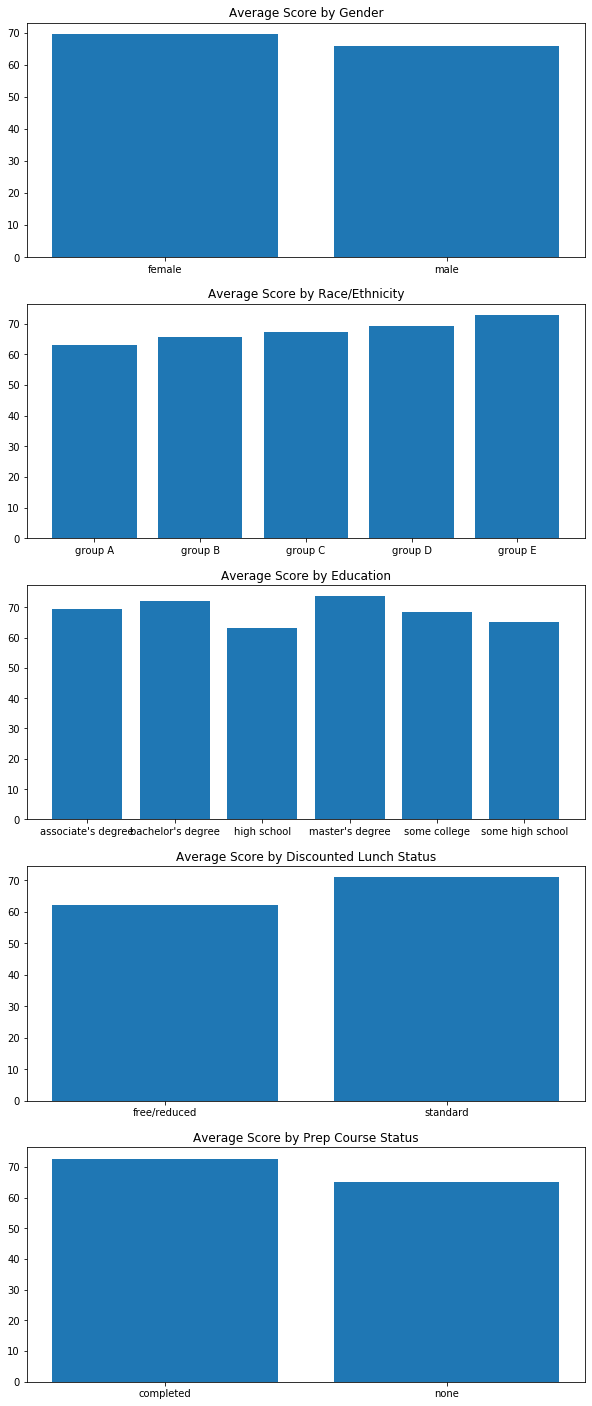

In [113]:
plt.figure(figsize=(10,25))

plt.subplot(5,1,1)
plt.bar(student.groupby('gender')['avg score'].mean().index, student.groupby('gender')['avg score'].mean())
plt.title('Average Score by Gender')

plt.subplot(5,1,2)
plt.bar(student.groupby('race/ethnicity')['avg score'].mean().index, student.groupby('race/ethnicity')['avg score'].mean())
plt.title('Average Score by Race/Ethnicity')

plt.subplot(5,1,3)
plt.bar(student.groupby('parental level of education')['avg score'].mean().index, student.groupby('parental level of education')['avg score'].mean())
plt.title('Average Score by Education')

plt.subplot(5,1,4)
plt.bar(student.groupby('lunch')['avg score'].mean().index, student.groupby('lunch')['avg score'].mean())
plt.title('Average Score by Discounted Lunch Status')

plt.subplot(5,1,5)
plt.bar(student.groupby('test preparation course')['avg score'].mean().index, student.groupby('test preparation course')['avg score'].mean())
plt.title('Average Score by Prep Course Status')

plt.show()

Parental level of education, discounted lunch status, and whether or not they took a prep course seem fairly predictive of test performance.